<a href="https://colab.research.google.com/github/tpeterz/happy-flix/blob/main/Alternative_Model_Testing/Model_Eval_with_Outside_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This colab notebook was created to perform model evaluation and testing.

# This model is **NOT** using our movie reviews dataset. This notebook is here purely to test on a new, separete dataset.
---
### Link to dataset used for testing the model:

[sentiment analysis - SIMA ANJALI](https://www.kaggle.com/datasets/simaanjali/emotion-analysis-based-on-text/)

---

### Link to model used with the above dataset:

[Jochen Hartmann - Emotion English DistilRoBERTa-base](https://huggingface.co/j-hartmann/emotion-english-distilroberta-base)
---
# Please note: This will require 'Secret' access
### When running in Google Colab this can easily be set in the left sidebar.
### This require a HuggingFace token, which can be easily created following these steps: [HuggingFace Secret Tokens](https://huggingface.co/docs/hub/en/security-tokens)

---
## This notebook outputs a set of accuracy scores from the model, listed below:



>         Phase      Loss  Accuracy  F1 Score  Precision    Recall  Runtime (s)  \
    Training  0.688114  0.780000  0.762148   0.780587  0.780000     104.7757   
    Validation  0.761094  0.746667  0.737896   0.758452  0.746667      17.4617   
    Testing  0.781530  0.733333  0.723335   0.726984  0.733333      30.6130   







# Getting started
### Import all required

In [ ]:
# A trick/shortcut to install all necessary libraries in one line of code
# Note: This may take a while.
# In colab, after installation, a session restart will be necessary.
# To perform this, use the tool bar at the top of the notebook and click 'Runtime'
# The dropdown menu will present a button "Restart Session". Select this, and then run all cells again.

# When running this after a session restart, it should display that all libraries were
    # installed "Requirement already satisfied...", and the cell will run much faster than before.

!pip install transformers datasets torch scikit-learn pandas

### Locate the file being used for this model evaluation in MyDrive

In [ ]:
!ls "/content/drive/MyDrive/emotion_sentimen_dataset.csv.zip"

/content/drive/MyDrive/emotion_sentimen_dataset.csv.zip


### Mount google drive to allow proper access
- Correct access will output "Drive already mounted at.."

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import the zip file and unzip
- Contents of the extracted csv file from the folder should look like

```
['emotion_sentimen_dataset.csv']

```



In [ ]:
import zipfile
import os

# This file is stored on Google Drive, and needs to be unzipped:
zip_path = '/content/drive/MyDrive/emotion_sentimen_dataset.csv.zip'

# Destination folder where contents will be extracted
extract_to = '/content/dataset'

# Create directory if it does not exist
os.makedirs(extract_to, exist_ok=True)

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Check the contents of the extracted folder
os.listdir(extract_to)

['emotion_sentimen_dataset.csv']

# File extraction and preview of the data frame `data`

In [ ]:
import pandas as pd
from sklearn.utils import resample
# Extracting after unzipped
data_file = os.path.join(extract_to, 'emotion_sentimen_dataset.csv')

In [ ]:
data = pd.read_csv(data_file)

In [ ]:
print(data['Emotion'].value_counts())

Emotion
neutral       674538
love           39553
happiness      27175
sadness        17481
relief         16729
hate           15267
anger          12336
fun            10075
enthusiasm      9304
surprise        6954
empty           5542
worry           4475
boredom          126
Name: count, dtype: int64


# Filter and Rename Classes
---
## Since the data from this dataset contain classes that are not used in the movie reviews analysis of predicted emotions using the model we will be using below, these need to be changed
- happiness = joy
---
# The process is as follows:
1. Replacing happiness with 'joy' by mapping
2.  Filtering this dataset for only the specific emotions needed in the classes
2.  Print to confirm operation successful

# The above code also shows that this dataset is highly skewed towards the `neutral` category of emotions. In order to prepare an adequate sample set, we must reduce this.
- This below process involves 'down-sampling'
---
# Before doing this, we can further adjust the dataset to fit our needs

In [ ]:
# Renaming 'happiness' to 'joy', then ensuring it is listed as this in value counts
data['Emotion'] = data['Emotion'].replace({'happiness': 'joy'})
print(data['Emotion'].value_counts())

Emotion
neutral       674538
love           39553
joy            27175
sadness        17481
relief         16729
hate           15267
anger          12336
fun            10075
enthusiasm      9304
surprise        6954
empty           5542
worry           4475
boredom          126
Name: count, dtype: int64


In [ ]:
# Filtering to include only the relevant emotions, then display new list of classes in 'Emotion' column
data = data[data['Emotion'].isin(['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'])]
print(data['Emotion'].value_counts())

Emotion
neutral     674538
joy          27175
sadness      17481
anger        12336
surprise      6954
Name: count, dtype: int64


In [ ]:
# Calculate the minimum class size (based on the smallest class)
min_class_size = data['Emotion'].value_counts().min()
print(min_class_size)

6954


# This dataset is too large for the basic Colab subscription
-  The way we are choosing to handle this, is by continuing this process for model evaluatio in a **subset** of this dataset

In [ ]:
# Sample data from each class to match the size of the smallest class
sampled_data = pd.DataFrame()  # Initialize an empty DataFrame to hold sampled data
for emotion in ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']:
    subset = data[data['Emotion'] == emotion]
    # Ensure the subset is not empty before sampling
    if not subset.empty:
        sampled_subset = resample(subset, replace=False, n_samples=min_class_size, random_state=42)
        sampled_data = pd.concat([sampled_data, sampled_subset])

In [ ]:
# Shuffle the sampled data
sampled_data = sampled_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# Check the first few rows and the new distribution of classes
print(sampled_data.head(20))
print(sampled_data['Emotion'].value_counts())

    Unnamed: 0                                               text   Emotion
0       734416                    i feel sad and stand one corner   sadness
1       266088  i feel sad for myself because i don t have the...   sadness
2       257312  i feel a pang of regret for getting so angry a...     anger
3       246314  some time ago a close relative of mine got off...   neutral
4       123456  i tend to find myself feeling passionate about...     anger
5       822319  i always feel super proud of myself when i fin...   neutral
6       485307  i am feeling it today the melancholy that visi...   sadness
7       499504  ive got a pretty good feeling about this one a...  surprise
8       519822  i feel surprised every time woohyun hyung make...  surprise
9       166658  i would like i go through all kinds of emotion...   neutral
10      714914       i needed to tell people that i feel tortured   neutral
11      323750  i still feel a little agitated but the agrevat...   neutral
12      7753

# Determine New Sample Size

In [ ]:
new_sample_size = 100  # Rather small, however, we need to work with what colab can handle

# Further Downsample Each Class

In [ ]:
import pandas as pd
from sklearn.utils import resample

downsampled_data = pd.DataFrame()

for emotion in sampled_data['Emotion'].unique():
    subset = sampled_data[sampled_data['Emotion'] == emotion]
    downsampled_subset = resample(subset, replace=False, n_samples=new_sample_size, random_state=42)
    downsampled_data = pd.concat([downsampled_data, downsampled_subset])

# Shuffle the downsampled data to mix the classes well
downsampled_data = downsampled_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new distribution of classes
print(downsampled_data['Emotion'].value_counts())

Emotion
surprise    100
sadness     100
anger       100
joy         100
neutral     100
Name: count, dtype: int64


#  Proceed with Data Preparation

In [ ]:
from sklearn.utils import resample
import pandas as pd

# Assume 'sampled_data' contains your previously balanced dataset
downsampled_data = pd.DataFrame()

for emotion in sampled_data['Emotion'].unique():
    subset = sampled_data[sampled_data['Emotion'] == emotion]
    # Check if the subset size is greater than the new sample size before downsampling
    if len(subset) >= new_sample_size:
        downsampled_subset = resample(subset, replace=False, n_samples=new_sample_size, random_state=42)
        downsampled_data = pd.concat([downsampled_data, downsampled_subset])
    else:
        # If the subset is smaller than the new sample size, take the subset as is
        downsampled_data = pd.concat([downsampled_data, subset])

# Shuffle the downsampled data to ensure it's well-mixed
downsampled_data = downsampled_data.sample(frac=1, random_state=42).reset_index(drop=True)

downsampled_data.head()

,Unnamed: 0,text,Emotion
0,469111,i feel surprised and astonished that i ve won ...,surprise
1,809908,i feel sad that i don t have a uterus so that ...,sadness
2,815727,i really think kids can sense good energies an...,surprise
3,502737,i really honestly feel like i am not smart eno...,anger
4,735256,my friend halfteasingly called me a bad nickna...,anger


# Validation of Sample Sizes:

In [ ]:
print(downsampled_data['Emotion'].value_counts())

Emotion
surprise    100
sadness     100
anger       100
joy         100
neutral     100
Name: count, dtype: int64


# Split the Data into Train, Validate, and Test Sets

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and the remainder (validation + test)
train_data, temp_data = train_test_split(downsampled_data, test_size=0.3, random_state=42, stratify=downsampled_data['Emotion'])

# Split the remainder into validation and test sets
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['Emotion'])

print("Training Set Size:", len(train_data))
print("Validation Set Size:", len(val_data))
print("Testing Set Size:", len(test_data))


Training Set Size: 350
Validation Set Size: 75
Testing Set Size: 75


# Tokenization

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")

def tokenize_data(data):
    return tokenizer(data['text'].tolist(), padding="max_length", truncation=True, max_length=128, return_tensors='pt')

train_encodings = tokenize_data(train_data)
val_encodings = tokenize_data(val_data)
test_encodings = tokenize_data(test_data)

In [ ]:
!pip install accelerate -U

# Set up Class method, as described in the model documentation/model card.

In [ ]:
import torch
from torch.utils.data import Dataset

class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Map labels to integers
label_dict = {label: idx for idx, label in enumerate(downsampled_data['Emotion'].unique())}
train_labels = [label_dict[label] for label in train_data['Emotion']]
val_labels = [label_dict[label] for label in val_data['Emotion']]
test_labels = [label_dict[label] for label in test_data['Emotion']]

# Create datasets
train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

# Finally, bring in the model

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "j-hartmann/emotion-english-distilroberta-base",
    num_labels=len(label_dict),
    problem_type="single_label_classification",
    ignore_mismatched_sizes=True

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Include this function, so that the model will output all scores after running `trainer.train()`

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    accuracy = accuracy_score(labels, preds)
    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

# Initialize the `Trainer`

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Execute cell to begin the training analysis
## Google Colab can only handle so much at once, so this is still a very small model evaluation set and actions.

In [ ]:
trainer.train()

<ipython-input-21-9d97b4b09c25>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.212200,1.052804,0.626667,0.583291,0.621135,0.626667
2,0.924200,0.821279,0.693333,0.656242,0.670782,0.693333
3,0.773000,0.761094,0.746667,0.737896,0.758452,0.746667


<ipython-input-21-9d97b4b09c25>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-21-9d97b4b09c25>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


TrainOutput(global_step=66, training_loss=1.0179596453002004, metrics={'train_runtime': 1223.0133, 'train_samples_per_second': 0.859, 'train_steps_per_second': 0.054, 'total_flos': 34774552512000.0, 'train_loss': 1.0179596453002004, 'epoch': 3.0})

# Print the results from the above function

In [ ]:
test_results = trainer.evaluate(test_dataset)
print(test_results)

<ipython-input-21-9d97b4b09c25>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 0.7815303802490234, 'eval_accuracy': 0.7333333333333333, 'eval_f1': 0.7233354231974922, 'eval_precision': 0.726984126984127, 'eval_recall': 0.7333333333333333, 'eval_runtime': 19.1342, 'eval_samples_per_second': 3.92, 'eval_steps_per_second': 0.523, 'epoch': 3.0}


In [ ]:
# Evaluate the model on the test dataset
test_results = trainer.evaluate(test_dataset)
print("Test Results:", test_results)

<ipython-input-21-9d97b4b09c25>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Test Results: {'eval_loss': 0.7815303802490234, 'eval_accuracy': 0.7333333333333333, 'eval_f1': 0.7233354231974922, 'eval_precision': 0.726984126984127, 'eval_recall': 0.7333333333333333, 'eval_runtime': 26.5719, 'eval_samples_per_second': 2.823, 'eval_steps_per_second': 0.376, 'epoch': 3.0}


# Plot the correlation matrix

<ipython-input-21-9d97b4b09c25>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


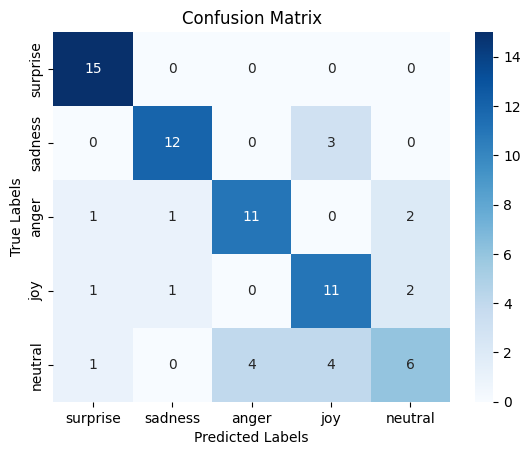

In [ ]:
# Obtain predictions for the test set
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = [label_dict[label] for label in test_data['Emotion']]

# Build a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_dict.keys(), yticklabels=label_dict.keys())

# Display the confusion matrix
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Install seaborn to plot further

In [ ]:
!pip install matplotlib seaborn

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = {
    'Accuracy': test_results.get('eval_accuracy', 0),
    'Precision': test_results.get('eval_precision', 0),
    'Recall': test_results.get('eval_recall', 0),
    'F1 Score': test_results.get('eval_f1', 0)
}

names = list(metrics.keys())
values = list(metrics.values())

# Bar Graph

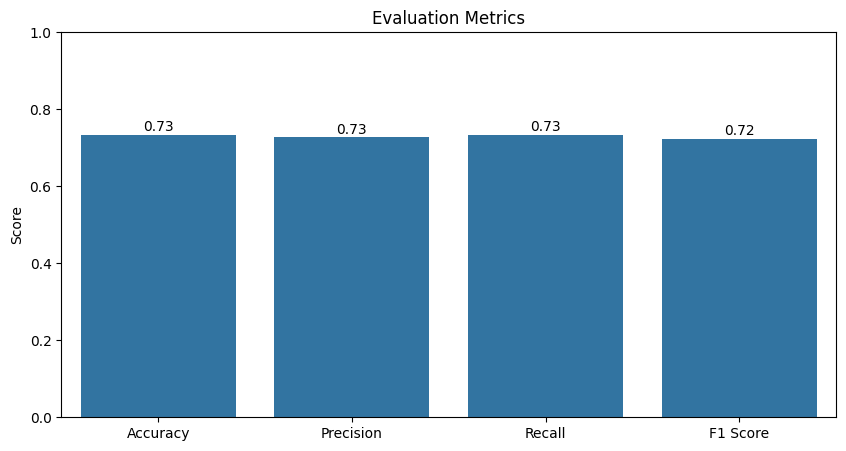

In [ ]:
# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=names, y=values)
plt.title('Evaluation Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
for i, value in enumerate(values):
    plt.text(i, value + 0.01, f'{value:.2f}', ha='center')
plt.show()

# Pie Chart

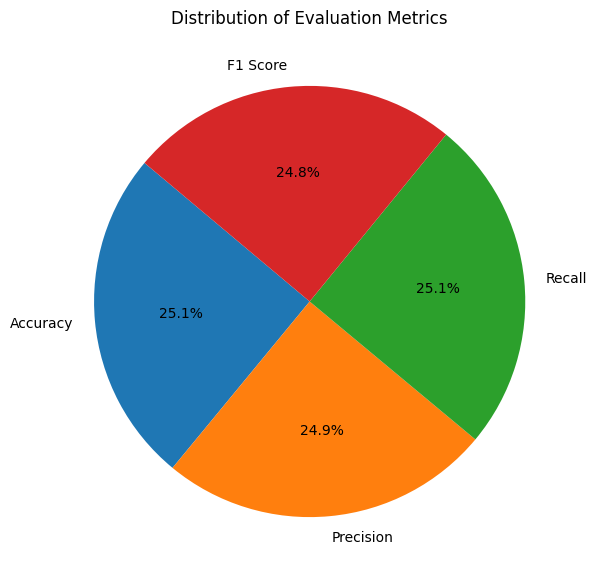

In [ ]:
plt.figure(figsize=(7, 7))
plt.pie(values, labels=names, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Evaluation Metrics')
plt.show()

# Plot the accuracy scores

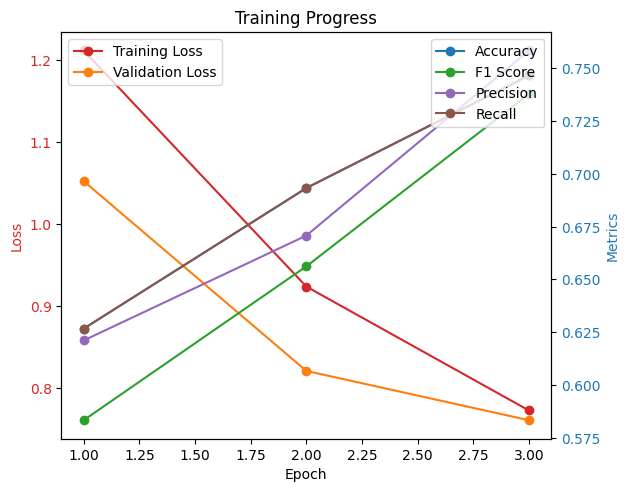

In [ ]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3]
training_loss = [1.2122, 0.9242, 0.7730]
validation_loss = [1.0528, 0.8213, 0.7611]
accuracy = [0.6267, 0.6933, 0.7467]
f1_scores = [0.5833, 0.6562, 0.7379]
precision = [0.6211, 0.6708, 0.7585]
recall = [0.6267, 0.6933, 0.7467]

# Create subplots
fig, ax1 = plt.subplots()

# Plot training and validation loss
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(epochs, training_loss, label='Training Loss', marker='o', color='tab:red')
ax1.plot(epochs, validation_loss, label='Validation Loss', marker='o', color='tab:orange')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.legend(loc='upper left')

# Create a second y-axis for the accuracy and other metrics
ax2 = ax1.twinx()
ax2.set_ylabel('Metrics', color='tab:blue')
ax2.plot(epochs, accuracy, label='Accuracy', marker='o', color='tab:blue')
ax2.plot(epochs, f1_scores, label='F1 Score', marker='o', color='tab:green')
ax2.plot(epochs, precision, label='Precision', marker='o', color='tab:purple')
ax2.plot(epochs, recall, label='Recall', marker='o', color='tab:brown')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.legend(loc='upper right')
fig.tight_layout()
plt.title('Training Progress')
plt.show()

# Retrieve model predictions on test dataset

In [ ]:
predictions = trainer.predict(test_dataset)

<ipython-input-21-9d97b4b09c25>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


# Convert the raw logits to probabilities

In [ ]:
# Apply softmax to logits to get probabilities
softmax = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1)

# Extract the probabilities for each class

In [ ]:
# Get probabilities for each class
probabilities = softmax.numpy()

# Create a DataFrame with the original texts and predictions

In [ ]:
original_texts = [text for text in test_data['text']]

# Map predicted indices to labels
predicted_labels = [model.config.id2label[pred] for pred in predictions.predictions.argmax(-1)]

# Create the DataFrame
df = pd.DataFrame({
    'text': original_texts,
    'predicted_label': predicted_labels,
    'probability_surprise': probabilities[:, 0],
    'probability_sadness': probabilities[:, 1],
    'probability_anger': probabilities[:, 2],
    'probability_joy': probabilities[:, 3],
    'probability_neutral': probabilities[:, 4]
})

### The emotions are being labeled automatically.
### To proceed, it would be useful to re-label these as the actual emotions.
#### The label "translations" are above, which will help when renaming

In [ ]:
print(df['predicted_label'].value_counts())

predicted_label
LABEL_3    18
LABEL_0    18
LABEL_2    15
LABEL_1    14
LABEL_4    10
Name: count, dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   text                  75 non-null     object 
 1   predicted_label       75 non-null     object 
 2   probability_surprise  75 non-null     float32
 3   probability_sadness   75 non-null     float32
 4   probability_anger     75 non-null     float32
 5   probability_joy       75 non-null     float32
 6   probability_neutral   75 non-null     float32
 7   predicted_emotion     75 non-null     object 
dtypes: float32(5), object(3)
memory usage: 3.3+ KB


# Changing the `predicted_label` column
### So that -
- Each label in the format of "LABEL_(A NUMBER)" would now show as the emotion it predicted after analysis

In [ ]:
df['predicted_label'] = df['predicted_label'].replace({'LABEL_0': 'surprise'})
df['predicted_label'] = df['predicted_label'].replace({'LABEL_1': 'sadness'})
df['predicted_label'] = df['predicted_label'].replace({'LABEL_2': 'anger'})
df['predicted_label'] = df['predicted_label'].replace({'LABEL_3': 'joy'})
df['predicted_label'] = df['predicted_label'].replace({'LABEL_4': 'neutral'})
df.head()

,text,predicted_label,probability_surprise,probability_sadness,probability_anger,probability_joy,probability_neutral
0,i don t want to feel like loving jesus is minu...,neutral,0.035003,0.092924,0.075295,0.381196,0.415582
1,i havent enjoyed a few treats because ive had ...,sadness,0.037477,0.389605,0.085379,0.280230,0.207310
2,i feel called to step out of the boat and have...,neutral,0.124428,0.133689,0.138322,0.158500,0.445061
3,i feel grief with the families whose children ...,sadness,0.034153,0.559583,0.071584,0.169725,0.164955
4,i still stumble when im tired my pronunciation...,anger,0.041735,0.086947,0.739807,0.061548,0.069963


In [ ]:
print(df['predicted_label'].value_counts())

predicted_label
joy         18
surprise    18
anger       15
sadness     14
neutral     10
Name: count, dtype: int64


# Printing all results:

# Test Dataset

In [ ]:
test_results = trainer.evaluate(test_dataset)
print(test_results)

<ipython-input-21-9d97b4b09c25>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 0.7815303802490234, 'eval_accuracy': 0.7333333333333333, 'eval_f1': 0.7233354231974922, 'eval_precision': 0.726984126984127, 'eval_recall': 0.7333333333333333, 'eval_runtime': 30.613, 'eval_samples_per_second': 2.45, 'eval_steps_per_second': 0.327, 'epoch': 3.0}


# Train Dataset

In [ ]:
train_results = trainer.evaluate(train_dataset)
print(train_results)

<ipython-input-21-9d97b4b09c25>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 0.6881137490272522, 'eval_accuracy': 0.78, 'eval_f1': 0.7621476783377955, 'eval_precision': 0.7805874489506852, 'eval_recall': 0.78, 'eval_runtime': 104.7757, 'eval_samples_per_second': 3.34, 'eval_steps_per_second': 0.42, 'epoch': 3.0}


In [ ]:
val_results = trainer.evaluate(val_dataset)
print(val_results)

<ipython-input-21-9d97b4b09c25>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 0.7610940337181091, 'eval_accuracy': 0.7466666666666667, 'eval_f1': 0.7378962131837308, 'eval_precision': 0.7584523809523809, 'eval_recall': 0.7466666666666667, 'eval_runtime': 17.4617, 'eval_samples_per_second': 4.295, 'eval_steps_per_second': 0.573, 'epoch': 3.0}


In [ ]:
import pandas as pd

# Define dictionaries for each set of results
train_results = {'eval_loss': 0.6881137490272522, 'eval_accuracy': 0.78, 'eval_f1': 0.7621476783377955, 'eval_precision': 0.7805874489506852, 'eval_recall': 0.78, 'eval_runtime': 104.7757, 'eval_samples_per_second': 3.34, 'eval_steps_per_second': 0.42, 'epoch': 3.0}
val_results = {'eval_loss': 0.7610940337181091, 'eval_accuracy': 0.7466666666666667, 'eval_f1': 0.7378962131837308, 'eval_precision': 0.7584523809523809, 'eval_recall': 0.7466666666666667, 'eval_runtime': 17.4617, 'eval_samples_per_second': 4.295, 'eval_steps_per_second': 0.573, 'epoch': 3.0}
test_results = {'eval_loss': 0.7815303802490234, 'eval_accuracy': 0.7333333333333333, 'eval_f1': 0.7233354231974922, 'eval_precision': 0.726984126984127, 'eval_recall': 0.7333333333333333, 'eval_runtime': 30.613, 'eval_samples_per_second': 2.45, 'eval_steps_per_second': 0.327, 'epoch': 3.0}

# Combine dictionaries into a DataFrame
results_df = pd.DataFrame({
    'Phase': ['Training', 'Validation', 'Testing'],
    'Loss': [train_results['eval_loss'], val_results['eval_loss'], test_results['eval_loss']],
    'Accuracy': [train_results['eval_accuracy'], val_results['eval_accuracy'], test_results['eval_accuracy']],
    'F1 Score': [train_results['eval_f1'], val_results['eval_f1'], test_results['eval_f1']],
    'Precision': [train_results['eval_precision'], val_results['eval_precision'], test_results['eval_precision']],
    'Recall': [train_results['eval_recall'], val_results['eval_recall'], test_results['eval_recall']],
    'Runtime (s)': [train_results['eval_runtime'], val_results['eval_runtime'], test_results['eval_runtime']],
    'Samples per Second': [train_results['eval_samples_per_second'], val_results['eval_samples_per_second'], test_results['eval_samples_per_second']],
    'Steps per Second': [train_results['eval_steps_per_second'], val_results['eval_steps_per_second'], test_results['eval_steps_per_second']],
    'Epoch': [train_results['epoch'], val_results['epoch'], test_results['epoch']]
})

# Print the DataFrame to verify
print(results_df)

        Phase      Loss  Accuracy  F1 Score  Precision    Recall  Runtime (s)  \
0    Training  0.688114  0.780000  0.762148   0.780587  0.780000     104.7757   
1  Validation  0.761094  0.746667  0.737896   0.758452  0.746667      17.4617   
2     Testing  0.781530  0.733333  0.723335   0.726984  0.733333      30.6130   

   Samples per Second  Steps per Second  Epoch  
0               3.340             0.420    3.0  
1               4.295             0.573    3.0  
2               2.450             0.327    3.0  


# More Graphs with the evaluation metrics

<ipython-input-81-6b379ae49ad3>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(x='Phase', y='Accuracy', data=results_df, palette='coolwarm')


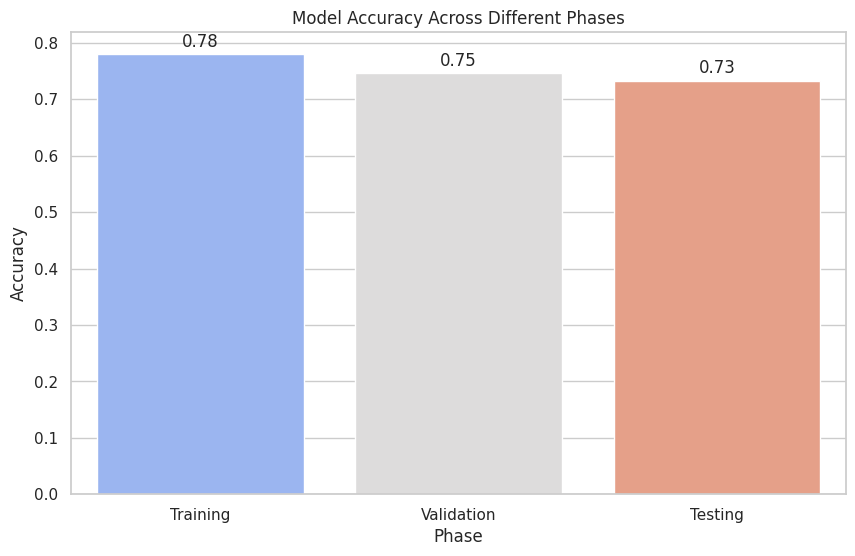

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set(style="whitegrid")

# Create the bar chart
plt.figure(figsize=(10, 6))
bar = sns.barplot(x='Phase', y='Accuracy', data=results_df, palette='coolwarm')
plt.title('Model Accuracy Across Different Phases')
plt.xlabel('Phase')
plt.ylabel('Accuracy')
for p in bar.patches:
    bar.annotate(format(p.get_height(), '.2f'),
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha = 'center', va = 'center',
                 xytext = (0, 9),
                 textcoords = 'offset points')
plt.show()


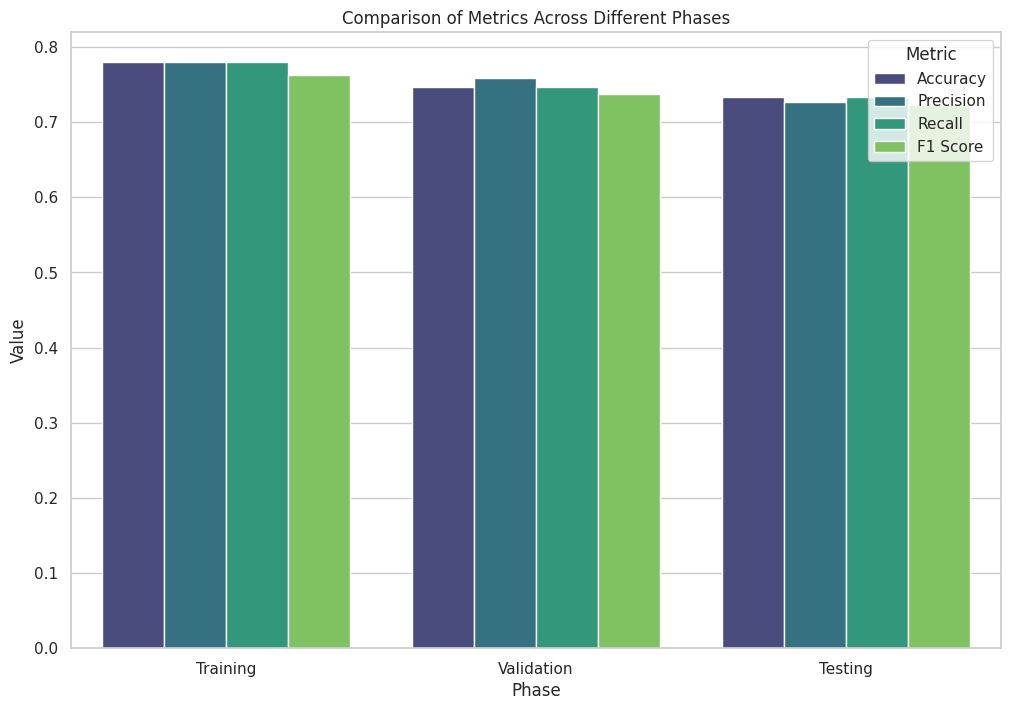

In [ ]:
# Melt the DataFrame and make suitable for sns.barplot with multiple categories
melted_df = results_df.melt(id_vars=["Phase"], value_vars=["Accuracy", "Precision", "Recall", "F1 Score"],
                            var_name="Metric", value_name="Value")

plt.figure(figsize=(12, 8))
sns.barplot(x='Phase', y='Value', hue='Metric', data=melted_df, palette='viridis')
plt.title('Comparison of Metrics Across Different Phases')
plt.xlabel('Phase')
plt.ylabel('Value')
plt.legend(title='Metric')
plt.show()

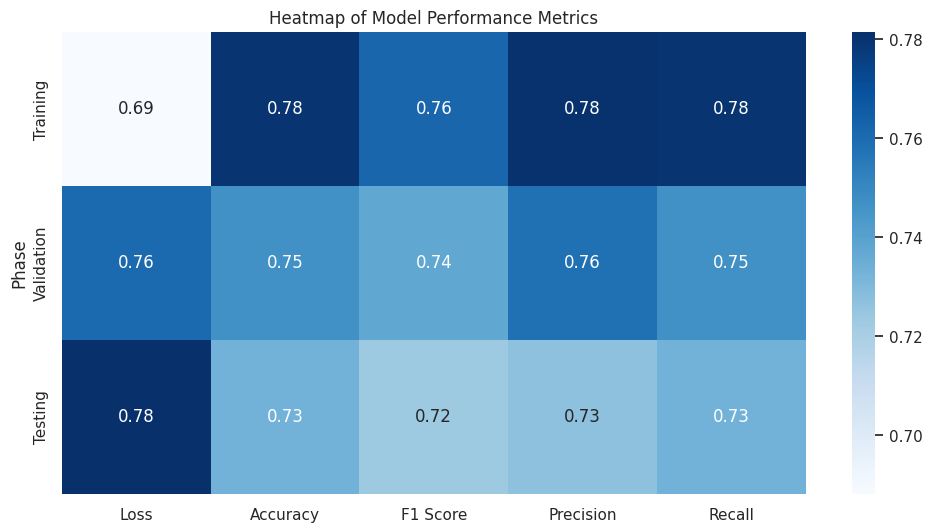

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming results_df is your DataFrame
# Set 'Phase' as the index to exclude it from the heatmap data
heatmap_df = results_df.set_index('Phase')

# Drop other non-numeric columns if necessary
heatmap_df = heatmap_df.drop(columns=['Epoch', 'Runtime (s)', 'Samples per Second', 'Steps per Second'])

# Now create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(data=heatmap_df, annot=True, fmt=".2f", cmap='Blues')
plt.title('Heatmap of Model Performance Metrics')
plt.show()

# Analyzing Model Performance:
---
# Accuracy scores obtained:

*   `accuracy`
*   `F1`
*   `precision`
*   `recall`

1. **Overfitting**: There is a gradual decrease in all metrics from training to testing. The differences are not dramatic but noticeable. The training accuracy (0.78) is higher than validation (0.747) and testing (0.733), which suggests a slight overfitting, as the model is slightly tuned to perform better on the training data than on unseen data.
2. **Underfitting**: The model shows reasonable performance on the training set (accuracy of 0.78), which suggests it is not underfitting. The model seems to have learned the patterns in the training data to some extent.
---
# Final thoughts of model performance:
---
The model shows some signs of good fitting but could be optimized further to reduce the performance gap between the training and testing results. The consistent drop in scores, while relatively small, points to potential overfitting.

--
# Although this dataset was not used for our analysis, we thought to analyze another similar dataset against this model to truly get a feel for it's performance